1078.6608040911185


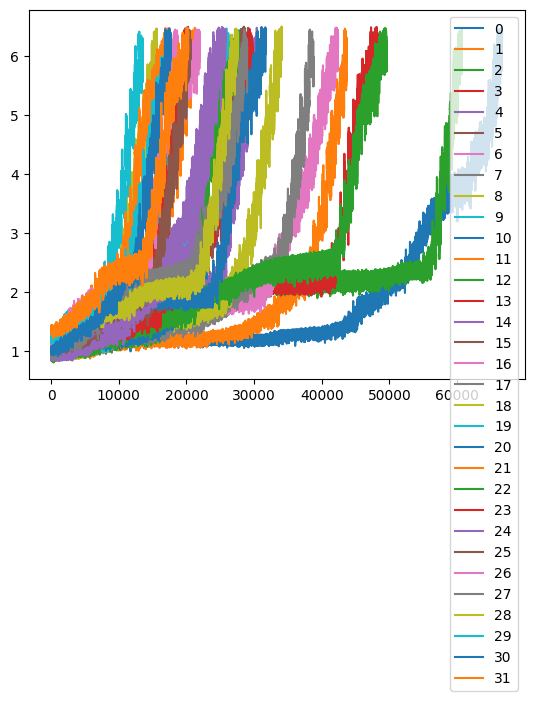

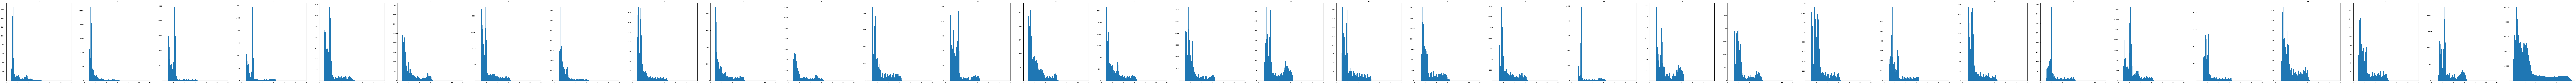

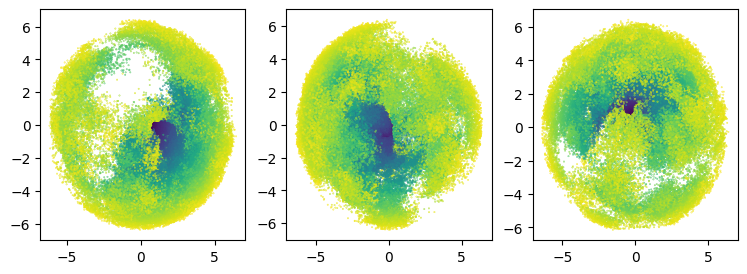

In [1]:
import os
import pickle
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

TIMESTEP_IN_REPLICA = 101
TEMPERATURE = 303.15

gleap_target = md.load("../2_md-preparation/gleap.target.gro")
protein_indices = gleap_target.topology.select("resid 5 to 48")
rna_indices = gleap_target.topology.select("resid 0 to 4")

pacs_com_dists = []
pacs_com_vectors = []
for trial in range(32):
    pickle_com_dists = pickle.load(open(f"./pickle-cache/com-feature/pacs_com_dists_{trial}.pickle", "rb"))
    n_replicas = int(len(pickle_com_dists)/TIMESTEP_IN_REPLICA)
    pacs_com_dists.append(pickle_com_dists.reshape((n_replicas, TIMESTEP_IN_REPLICA, 1)))
    pickle_com_vectors = pickle.load(open(f"./pickle-cache/com-feature/pacs_com_vectors_{trial}.pickle", "rb"))
    pacs_com_vectors.append(pickle_com_vectors.reshape((n_replicas, TIMESTEP_IN_REPLICA, 3)))

for trial in range(len(pacs_com_dists)):
    plt.plot(np.concatenate(pacs_com_dists[trial])[::10], label=trial)
plt.legend()

all_com_dists   = np.concatenate(np.concatenate(pacs_com_dists))
all_com_vectors = np.concatenate(np.concatenate(pacs_com_vectors))
all_com_vectors_hull = ConvexHull(all_com_vectors)
print(all_com_vectors_hull.volume)

fig_dists, ax_dists = plt.subplots(1, len(pacs_com_dists)+1)
fig_dists.set_size_inches(10*(len(pacs_com_dists)+1), 10)
for trial in range(len(pacs_com_dists)):
    ax_dists[trial].hist(np.concatenate(pacs_com_dists[trial])[::10], bins=50)
    ax_dists[trial].set_title(trial)
    ax_dists[trial].set_xlim(0, 12)
ax_dists[-1].hist(all_com_dists, bins=100)

fig_vectors, ax_vectors = plt.subplots(1, 3)
fig_vectors.set_size_inches(9, 3)
ax_vectors[0].scatter(all_com_vectors[:,0][::10], all_com_vectors[:,1][::10], s=0.1, c=all_com_dists[::10])
ax_vectors[1].scatter(all_com_vectors[:,1][::10], all_com_vectors[:,2][::10], s=0.1, c=all_com_dists[::10])
ax_vectors[2].scatter(all_com_vectors[:,2][::10], all_com_vectors[:,0][::10], s=0.1, c=all_com_dists[::10])

/work18/kijima/programs/anaconda3/envs/jupyter/lib/python3.10/site-packages/deeptime/clustering/_regspace.py:152: UserWarning: Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
  warnings.warn('Maximum number of cluster centers reached.'


0 15 finished
1 15 finished
2 15 finished
3 15 finished
4 15 finished
5 15 finished
6 15 finished
7 15 finished
8 15 finished
9 15 finished
10 15 finished
11 15 finished
12 15 finished
13 15 finished
14 15 finished
15 15 finished
16 15 finished
17 15 finished
18 15 finished
19 15 finished
20 15 finished
21 15 finished
22 15 finished
23 15 finished
24 15 finished
25 15 finished
26 15 finished
27 15 finished
28 15 finished
29 15 finished
30 15 finished
31 15 finished


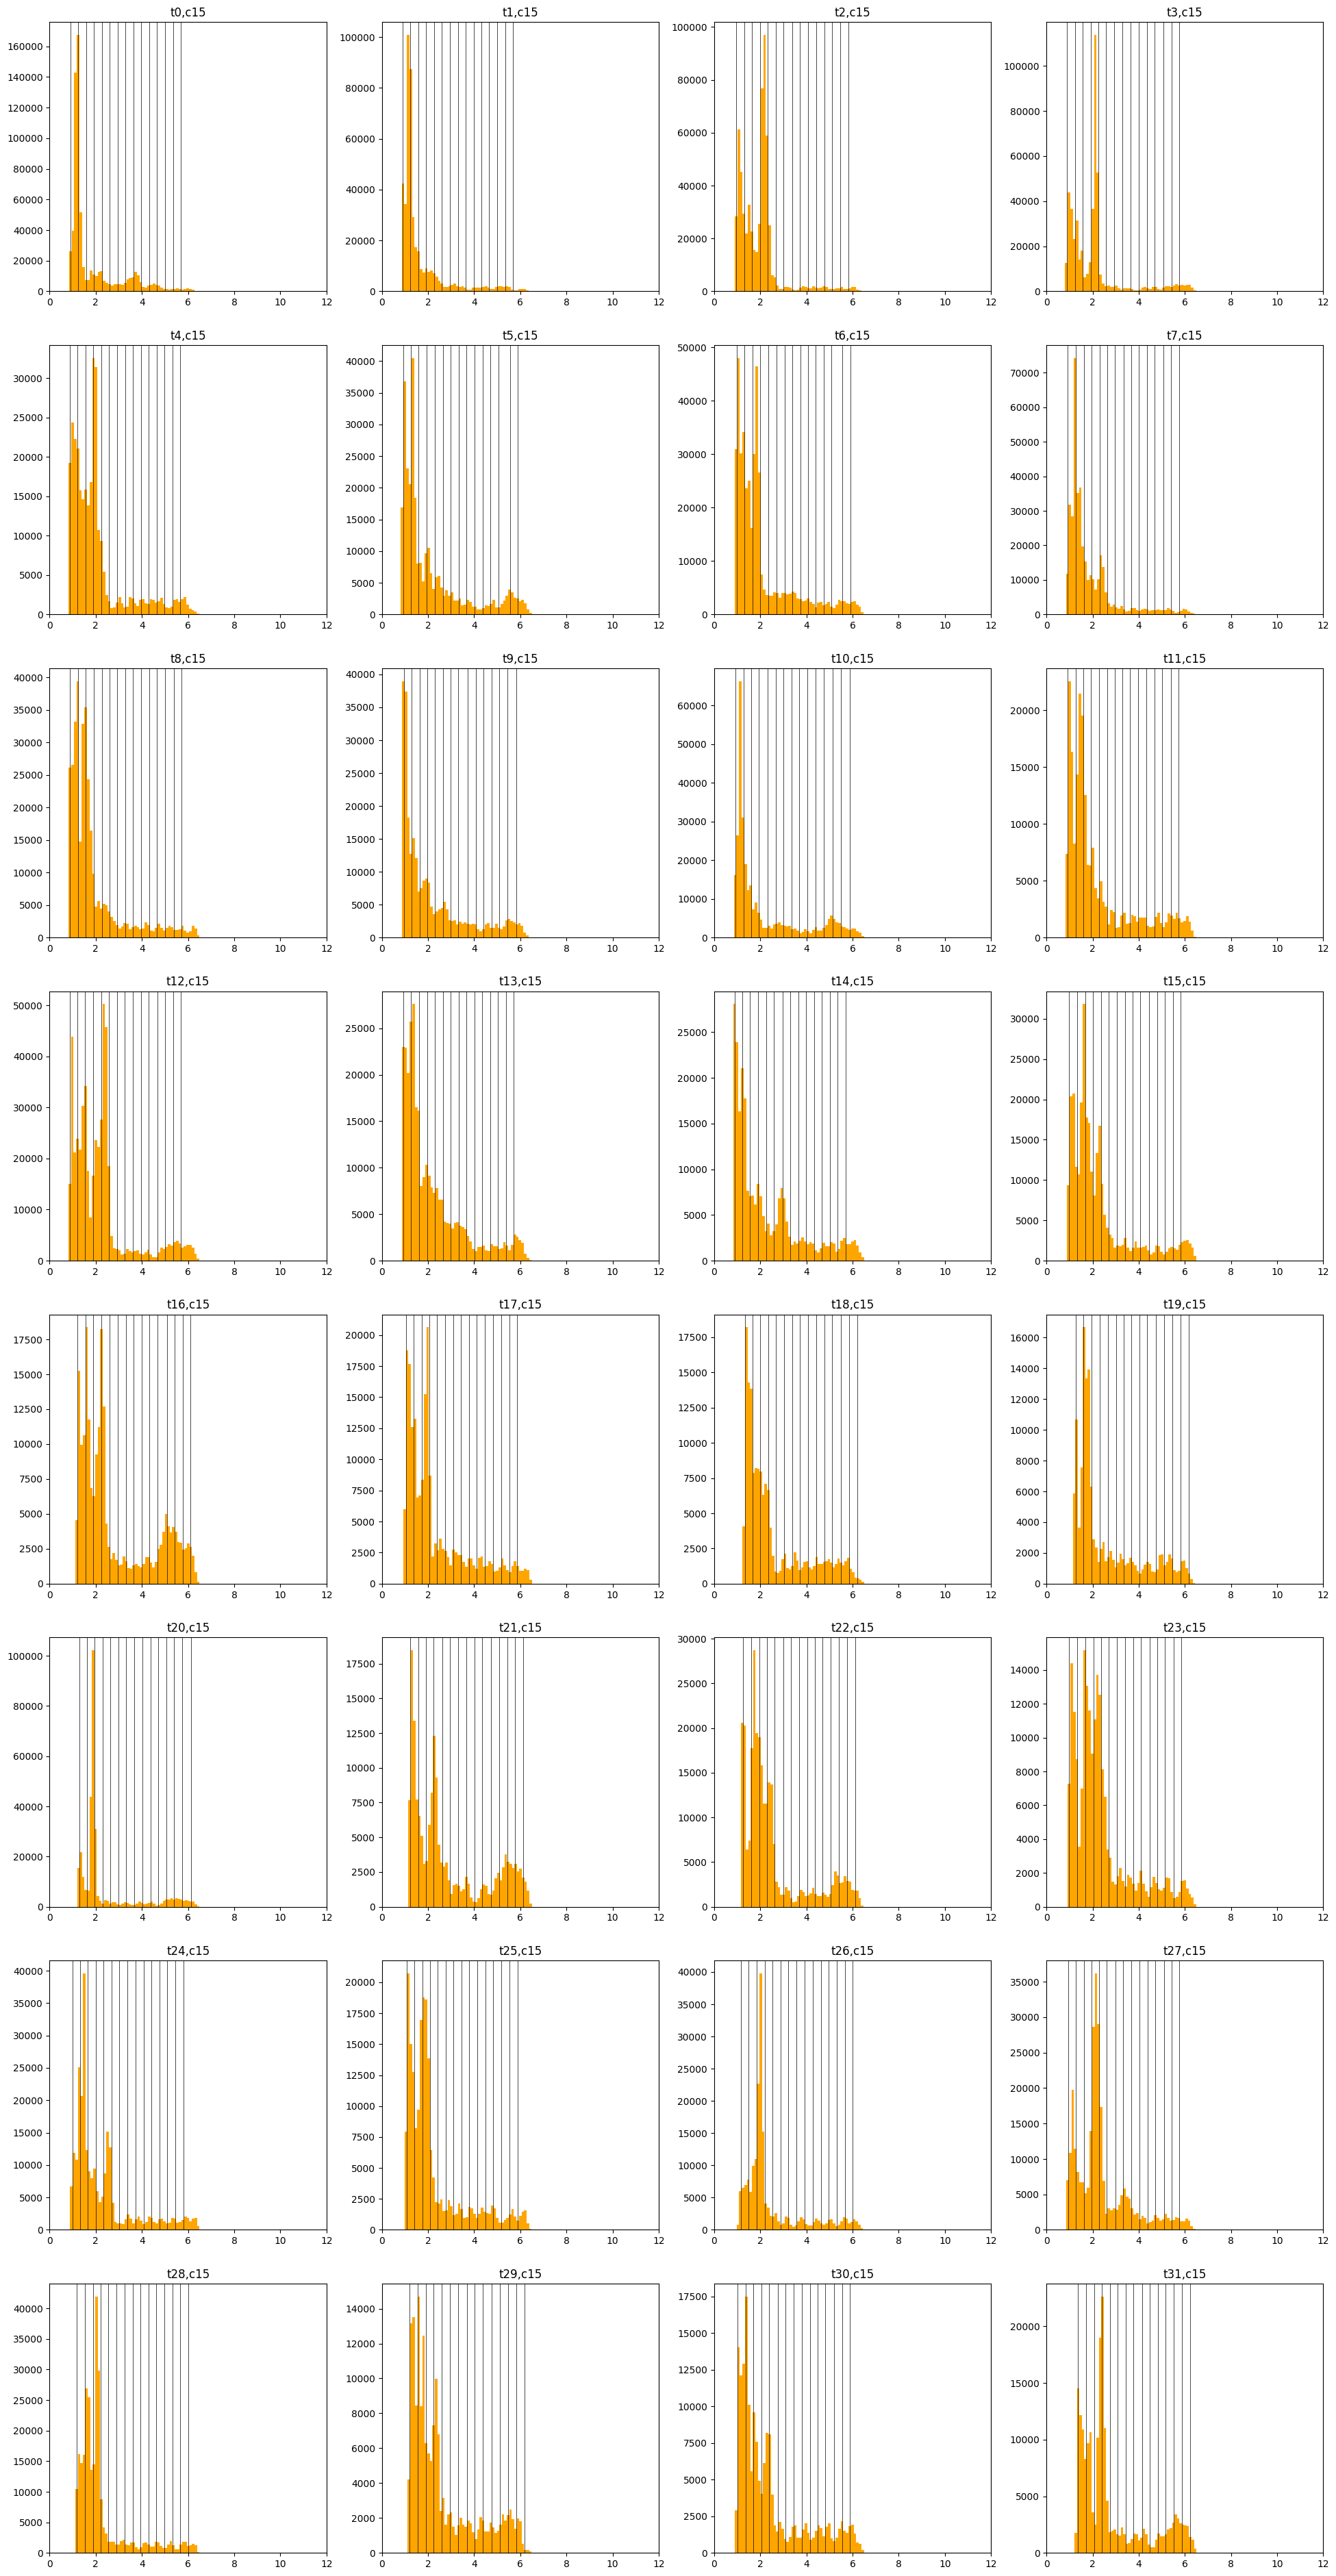

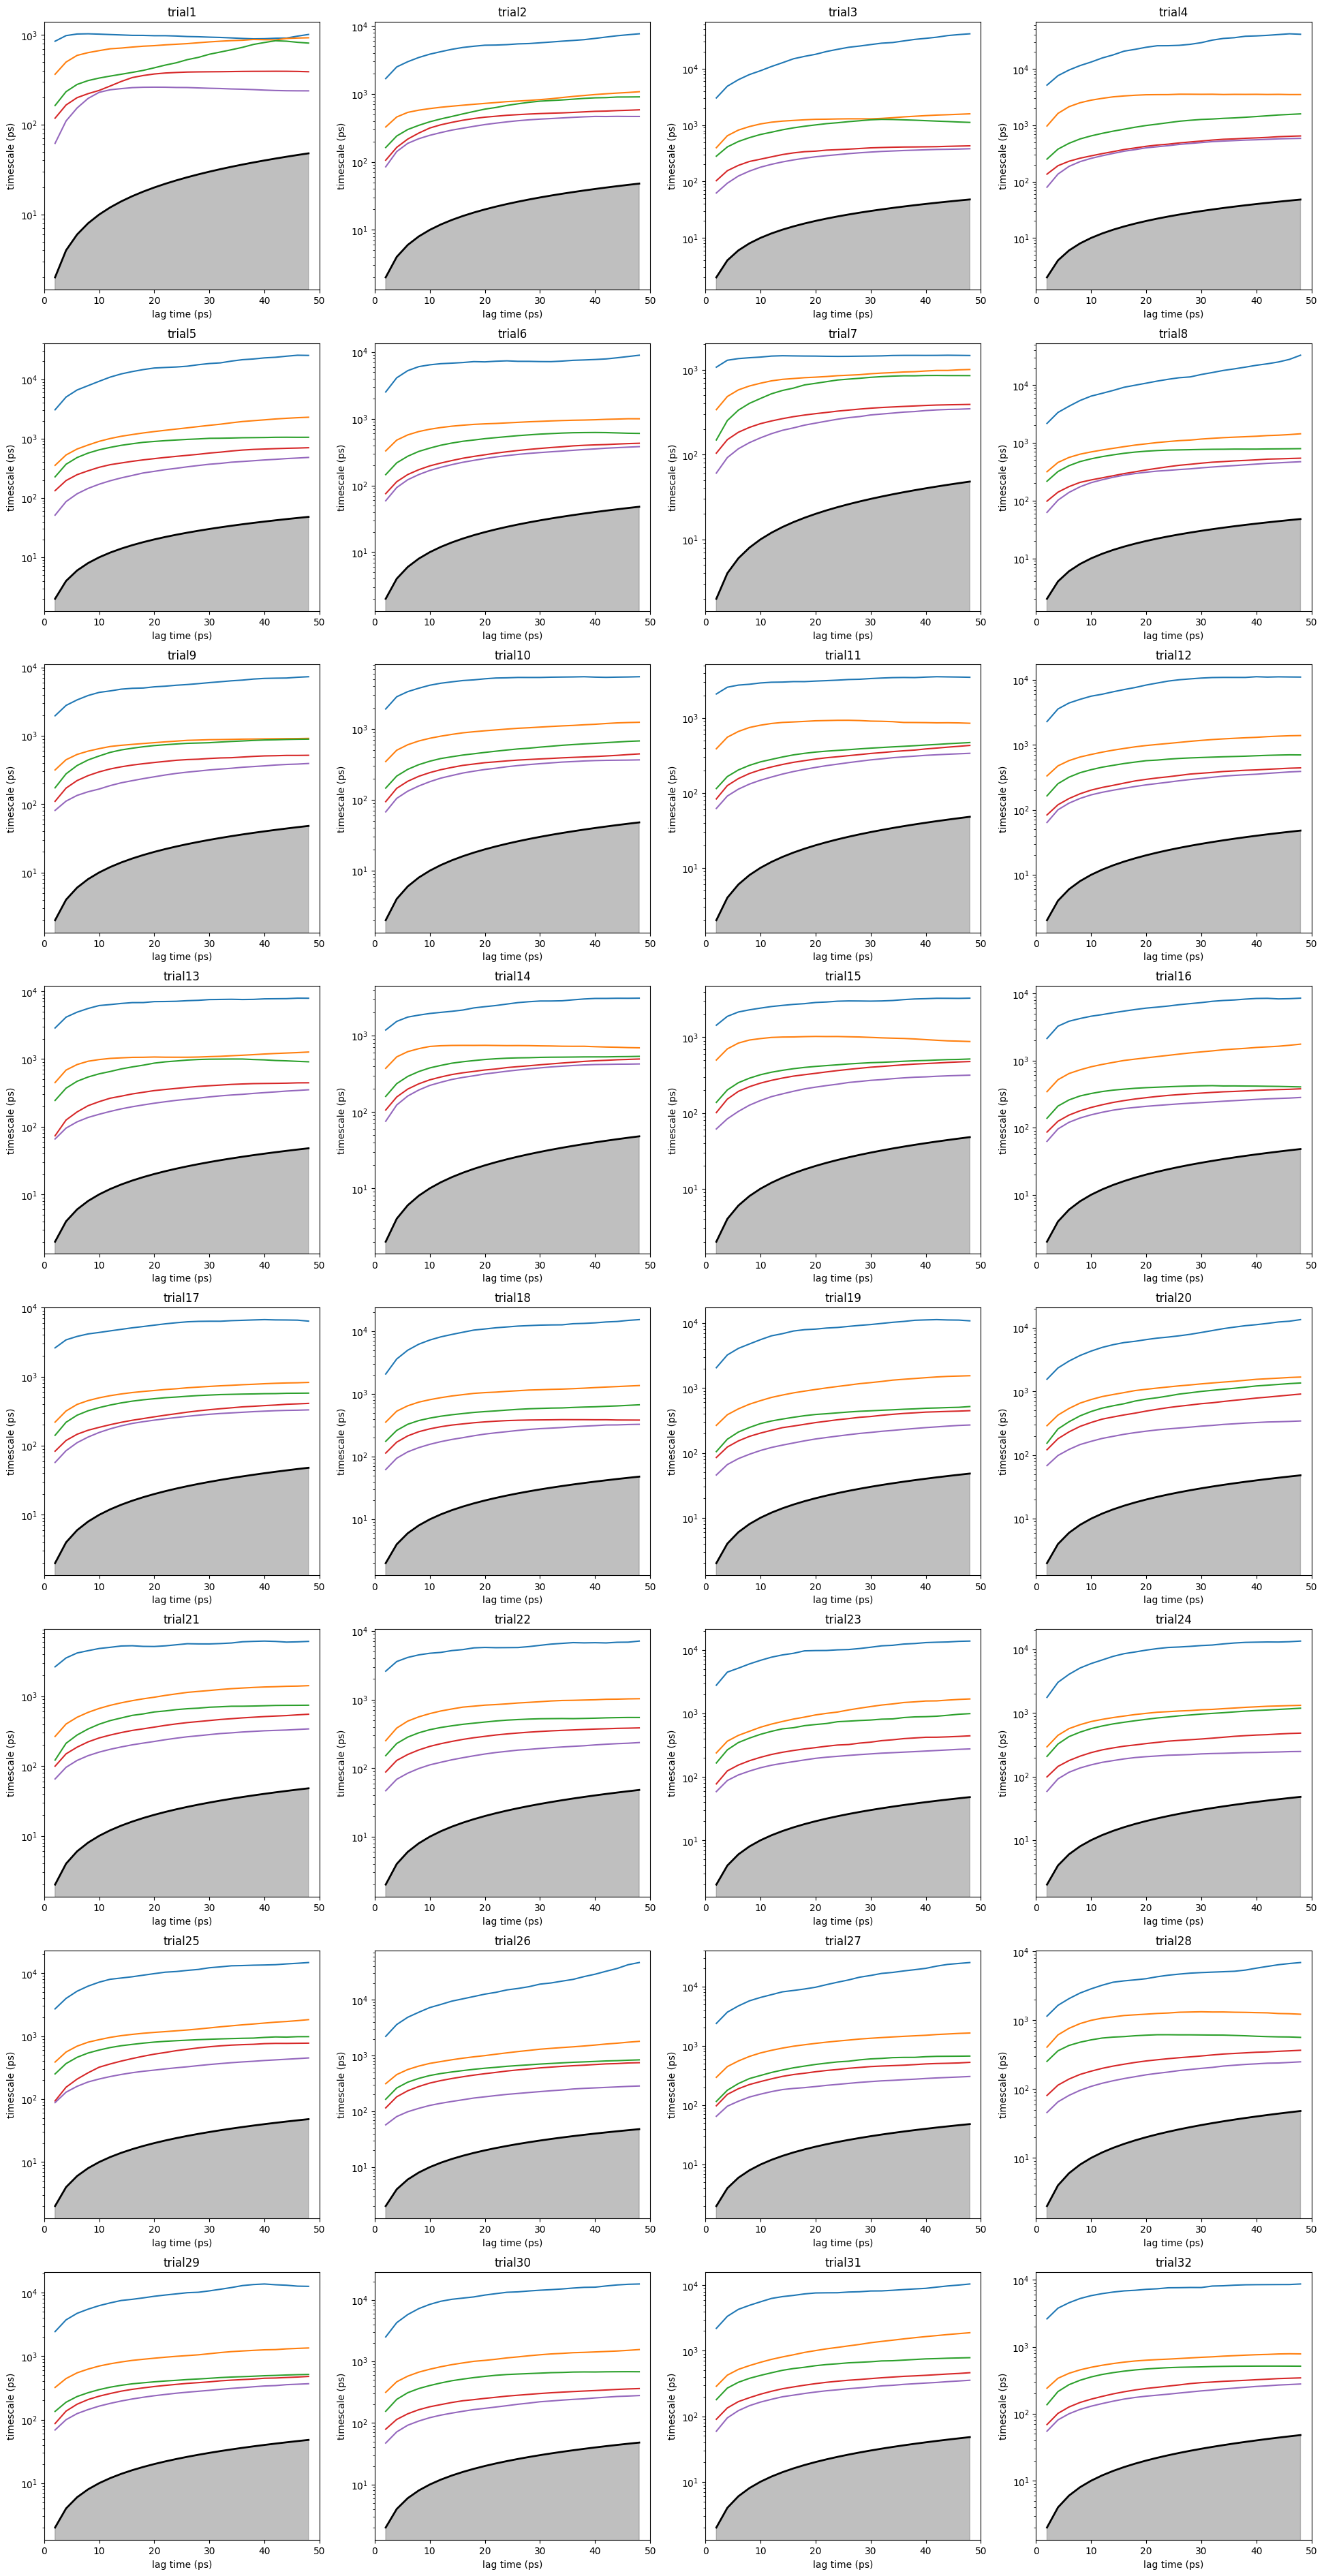

In [2]:
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov.msm import BayesianMSM
from deeptime.markov.tools import estimation
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

n_clusters = 15
i_n_clusters = 0

fig_cluster, ax_cluster = plt.subplots(8, 4)
fig_cluster.set_size_inches(24, 48)

fig_its, ax_its = plt.subplots(8, 4)
fig_its.set_size_inches(24, 48)

pacs_clustering_models = [None for _ in range(len(pacs_com_dists))]
pacs_pmfs = [None for _ in range(len(pacs_com_dists))]
pacs_stationary_distributions = [None for _ in range(len(pacs_com_dists))]

for trial in range(len(pacs_com_dists)):
    pacs_pmfs[trial] = {}
    pacs_clustering_models[trial] = {}
    pacs_stationary_distributions[trial] = {}

    trajs = pacs_com_dists[trial]
    trajs_concat = np.concatenate(trajs)

    pacs_pmfs[trial][n_clusters] = {}
    pacs_stationary_distributions[trial][n_clusters] = {}

    cluster_builder = RegularSpace(
        dmin=5/n_clusters,
        max_centers=n_clusters,
        metric="euclidean",
        n_jobs=None
    )
    
    cluster_builder.fit(trajs_concat)
    clustering_model = cluster_builder.fetch_model()
    clustered_trajs = [clustering_model.transform(traj) for traj in trajs]
    pacs_clustering_models[trial][n_clusters] = clustering_model

    ax_cluster[trial//4][trial%4].set_title(f"t{trial},c{n_clusters}")
    ax_cluster[trial//4][trial%4].hist(trajs_concat, bins=50, color="orange")
    ax_cluster[trial//4][trial%4].set_xlim(0, 12)
    for cluster_center in clustering_model.cluster_centers:
        ax_cluster[trial//4][trial%4].axvline(cluster_center, color="black", linewidth=0.5)

    msm_models = {}
    for lagtime in range(2, int(TIMESTEP_IN_REPLICA/2), 2):
        count_builder = TransitionCountEstimator(
            lagtime=lagtime,
            count_mode="sliding",
            n_states=None,
            sparse=False,
        )
        count_builder.fit(clustered_trajs)
        count_model = count_builder.fetch_model()

        msm_builder = MaximumLikelihoodMSM(
            reversible=True,
            stationary_distribution_constraint=None,
            sparse=False,
            allow_disconnected=False,
            maxiter=1000000,
            maxerr=1e-12,
            connectivity_threshold=0,
            transition_matrix_tolerance=1e-12,
            lagtime=None,
            use_lcc=False,
        )

        try:
            msm_builder.fit(count_model)
        except Exception as e:
            print(trial, "msm ng", n_clusters, lagtime, e)
            continue
        msm_model = msm_builder.fetch_model()
        if len(clustering_model.cluster_centers) != msm_model.n_states:
            print(trial, "n_states and n_cluster different", n_clusters, lagtime)
        msm_models[lagtime] = msm_model

        largest_connected_set = estimation.largest_connected_set(count_model.count_matrix, directed=True)
        stationary_distribution = np.zeros(clustering_model.n_clusters)
        stationary_distribution[largest_connected_set] = msm_model.stationary_distribution
        pacs_stationary_distributions[trial][n_clusters][lagtime] = stationary_distribution

        pmfs = np.zeros(len(stationary_distribution))
        for i_state, distribution in enumerate(stationary_distribution):
            pmfs[i_state] = -np.log(distribution/max(stationary_distribution))
        pmfs *= 1.38e-23
        pmfs *= TEMPERATURE
        pmfs *= 6.02e23
        pmfs /= 4.19*1000
        pacs_pmfs[trial][n_clusters][lagtime] = pmfs

    its = implied_timescales([model for model in msm_models.values()])
    plot_implied_timescales(
        its,
        n_its=5,
        ax=ax_its[trial//4][trial%4],
        process=None,
        show_mle=True,
        show_sample_mean=True,
        show_sample_confidence=True,
        show_cutoff=True,
        sample_confidence=0.95,
        colors=None,
    )
    ax_its[trial//4][trial%4].set_xlim(0, 50)
    ax_its[trial//4][trial%4].set_yscale('log')
    ax_its[trial//4][trial%4].set_title(f"trial{trial+1}")
    ax_its[trial//4][trial%4].set_xlabel("lag time (ps)")
    ax_its[trial//4][trial%4].set_ylabel("timescale (ps)")
    print(trial, n_clusters, "finished")

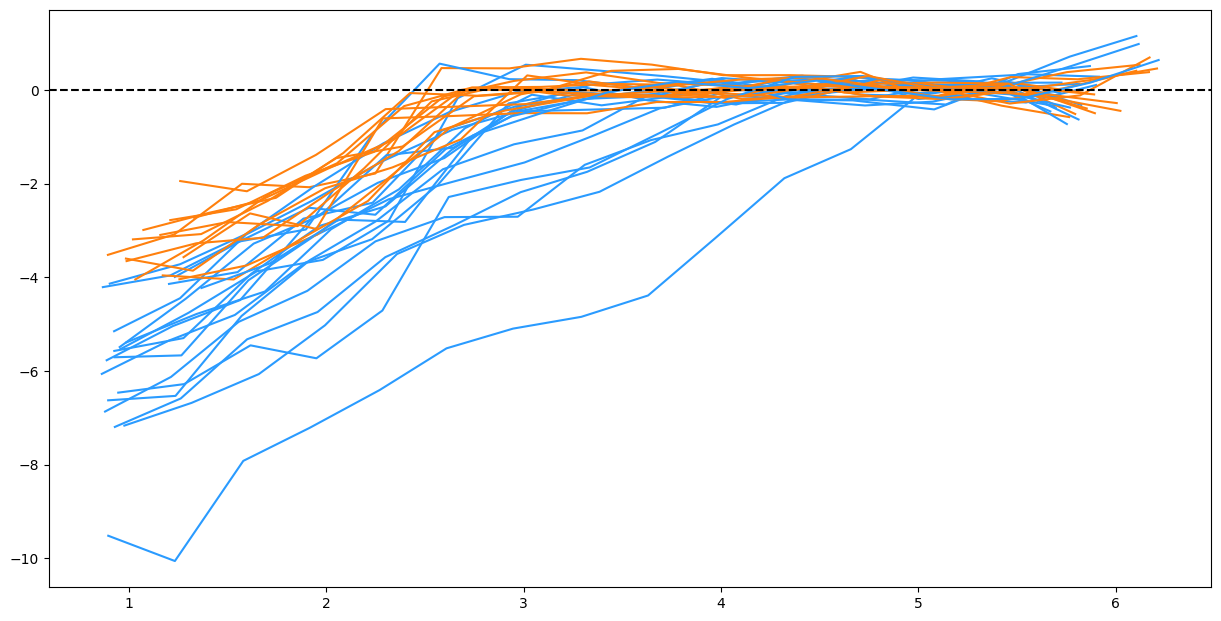

In [8]:
pacs_n_clusters = [15 for _ in range(len(pacs_com_dists))]
pacs_lagtimes = [20 for _ in range(len(pacs_com_dists))]

unstable_trials = [19,18,30,26,29,25,17,23,20,28,3,22,24,21,4,31,16,11,7,2,5,15,9,8,1,10,12,27,13,14,6,0][:13]
stable_trials = [val for val in range(32) if not val in unstable_trials]

plt.figure(figsize=(15, 7.5))
for trial in range(len(pacs_com_dists)):
    n_clusters = pacs_n_clusters[trial]
    lagtime = pacs_lagtimes[trial]
    clustering_model = pacs_clustering_models[trial][n_clusters]
    pmfs = pacs_pmfs[trial][n_clusters][lagtime]

    distance_pmf = []
    for cluster_center, pmf in zip(clustering_model.cluster_centers, pmfs):
        distance = np.linalg.norm(cluster_center)
        distance_pmf.append((distance, pmf))
    distance_pmf.sort(key=lambda a: a[0])
    unbound_average = np.average([val[1] for val in distance_pmf if 4 <= val[0] <= 6])
    if trial == 0:
        unbound_average = np.average([val[1] for val in distance_pmf if 5 <= val[0] <= 6])
    color = "#FF800D"
    if trial in stable_trials:
        color="#2A9BFF"
    plt.plot([val[0] for val in distance_pmf], [val[1]-unbound_average for val in distance_pmf], label=f"trial{trial+1}", c=color)
# plt.legend()
plt.axhline(0 , linestyle="--", color="black")

In [9]:
pacs_bound_thresholds = [1.5 for _ in range(len(pacs_com_dists))]
pacs_unbound_thresholds = [4 for _ in range(len(pacs_com_dists))]
pacs_g_pmfs = np.zeros(len(pacs_com_dists))

for trial in range(len(pacs_com_dists)):
    probabilities = []
    for cluster_center, stationary_distributions in zip(pacs_clustering_models[trial][n_clusters].cluster_centers, pacs_stationary_distributions[trial][n_clusters][lagtime]):
        distance =  np.linalg.norm(cluster_center)
        probabilities.append((distance, stationary_distributions))

    bound_probability = 0
    unbound_probability = 0
    for kv in probabilities:
        if kv[0] <= pacs_bound_thresholds[trial]:
            bound_probability+=kv[1]
        elif kv[0] >= pacs_unbound_thresholds[trial]:
            unbound_probability+=kv[1]
    g_pmf = -np.log(bound_probability/unbound_probability)
    g_pmf *= 1.38e-23
    g_pmf *= TEMPERATURE
    g_pmf *= 6.02e23
    g_pmf /= 4.19e3
    pacs_g_pmfs[trial] = g_pmf

pacs_volume_corrections = np.zeros(len(pacs_com_dists))
for trial in range(len(pacs_com_dists)):
    unbound_com_vectors = []
    for i_com_vectors in range(len(pacs_com_vectors[trial])):
        com_vectors = pacs_com_vectors[trial][i_com_vectors]
        for timestep in range(len(com_vectors)):
            if pacs_unbound_thresholds[trial] < pacs_com_dists[trial][i_com_vectors][timestep]:
                unbound_com_vectors.append(com_vectors[timestep])
    hull = ConvexHull(unbound_com_vectors)
    volume = hull.volume
    volume_correction = -np.log(volume/1.661)
    volume_correction *= 1.38e-23
    volume_correction *= TEMPERATURE
    volume_correction *= 6.02e23
    volume_correction /= 4.19e3
    pacs_volume_corrections[trial] = volume_correction

pacs_g_stds = pacs_g_pmfs + pacs_volume_corrections
for trial in range(len(pacs_com_dists)):
    print(trial, pacs_g_pmfs[trial], pacs_volume_corrections[trial], pacs_g_stds[trial])
print()
print("average", np.average(pacs_g_pmfs), np.average(pacs_volume_corrections), np.average(pacs_g_stds))
print("std    ", np.std    (pacs_g_pmfs), np.std    (pacs_volume_corrections), np.std    (pacs_g_stds))

0 -8.131874227003125 -2.3020218819664056 -10.433896108969531
1 -5.9882985134086715 -2.112552552123511 -8.100851065532183
2 -4.511708902488521 -2.361295544113386 -6.873004446601907
3 -2.573146177622787 -3.105114949919816 -5.678261127542603
4 -3.488532027943918 -2.6366846743399766 -6.125216702283895
5 -4.207968763838538 -3.097629582867835 -7.305598346706374
6 -6.1749106234793985 -3.1150718099795607 -9.28998243345896
7 -4.669872306310637 -1.8504851570966871 -6.520357463407324
8 -4.935324529999643 -2.6918705437891823 -7.627195073788825
9 -4.498644569799252 -2.943793379929876 -7.442437949729127
10 -4.957362201910782 -3.3084357209780633 -8.265797922888845
11 -3.4016751918849173 -2.886238688252847 -6.287913880137764
12 -5.229075027790718 -3.18404290871685 -8.413117936507568
13 -6.289903736948607 -2.7511511820720065 -9.041054919020613
14 -6.004080222061151 -3.0903911187906963 -9.094471340851847
15 -4.453338789136707 -2.9722836759948046 -7.425622465131511
16 -3.0527474293657018 -3.2211781067120

In [10]:
pacs_g_stds_ordered = []
for trial, g_std in enumerate(pacs_g_stds):
    pacs_g_stds_ordered.append((trial,  g_std))
pacs_g_stds_ordered.sort(key=lambda x: x[1], reverse=True)

print(pacs_g_stds_ordered)
print(f"[{','.join([str(val[0]) for val in pacs_g_stds_ordered])}]")

[(19, -3.4383222715529755), (18, -4.064455225716387), (30, -4.48612942287419), (26, -4.624781171615315), (29, -4.683410979897177), (25, -4.933236290336003), (17, -5.118835703750063), (23, -5.521004724688876), (20, -5.522645853979005), (28, -5.678007148970815), (3, -5.678261127542603), (22, -5.93031226290956), (24, -5.966115973285376), (21, -6.022353770917038), (4, -6.125216702283895), (31, -6.224672440089437), (16, -6.2739255360777175), (11, -6.287913880137764), (7, -6.520357463407324), (2, -6.873004446601907), (5, -7.305598346706374), (15, -7.425622465131511), (9, -7.442437949729127), (8, -7.627195073788825), (1, -8.100851065532183), (10, -8.265797922888845), (12, -8.413117936507568), (27, -8.424109846287314), (13, -9.041054919020613), (14, -9.094471340851847), (6, -9.28998243345896), (0, -10.433896108969531)]
[19,18,30,26,29,25,17,23,20,28,3,22,24,21,4,31,16,11,7,2,5,15,9,8,1,10,12,27,13,14,6,0]


-7.641662086757253 -5.049655242855257


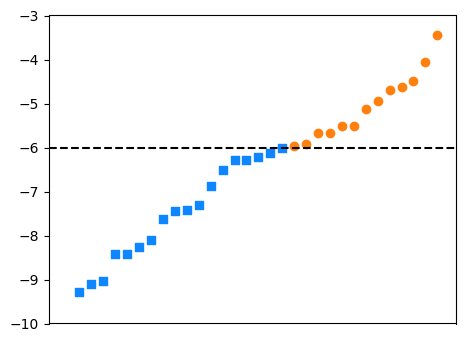

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5.25, 4)
ax.set_ylim(-10,  -3)

HIGH_LOW_THRESHOLD = -6

column = 0
stable_g_stds = []
unstable_g_stds = []
for trial, g_std in pacs_g_stds_ordered[::-1]:
    color = "#0D86FF"
    marker = ","
    if g_std > HIGH_LOW_THRESHOLD:
        color = "#FF800D"
        marker = "o"
        unstable_g_stds.append(g_std)
    else:
        stable_g_stds.append(g_std)
    ax.scatter(column, g_std, color=color, marker=marker)
    column += 1
ax.axhline(HIGH_LOW_THRESHOLD , linestyle="--", color="black")
ax.set_xticks([])

print(np.average(stable_g_stds), np.average(unstable_g_stds))

In [12]:
print(np.average(pacs_g_pmfs), np.average(pacs_g_pmfs[stable_trials]), np.average(pacs_g_pmfs[unstable_trials]))
print(np.std(pacs_g_pmfs), np.std(pacs_g_pmfs[stable_trials]), np.std(pacs_g_pmfs[unstable_trials]))
print()
print(np.average(pacs_volume_corrections), np.average(pacs_volume_corrections[stable_trials]), np.average(pacs_volume_corrections[unstable_trials]))
print(np.std(pacs_volume_corrections), np.std(pacs_volume_corrections[stable_trials]), np.std(pacs_volume_corrections[unstable_trials]))
print()
print(np.average(pacs_g_stds), np.average(pacs_g_stds[stable_trials]), np.average(pacs_g_stds[unstable_trials]))
print(np.std(pacs_g_stds), np.std(pacs_g_stds[stable_trials]), np.std(pacs_g_stds[unstable_trials]))

-3.803544322186876 -4.820640023570892 -2.317019835548699
1.6488579823560154 1.3220654073698115 0.6449900114815084

-2.7851149842351908 -2.82102206318636 -2.7326354073065593
0.38371949269398187 0.3988234459089162 0.35401626051666735

-6.588659306422066 -7.641662086757253 -5.049655242855257
1.658295351787348 1.236950575727093 0.7374011276101149
